In [155]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## 1. clean and preprocess data

In [156]:
def clean_data(df):
    """
    Cleans the data by handling missing/odd values in the RET and PRC columns.
    
    For RET:
      - Replaces the special missing codes (-66.0, -77.0, -88.0, -99.0) with NaN.
    
    For PRC:
      - If the price is 0, it is set to NaN.
      - If the price is negative, its absolute value is taken (the negative sign is a symbol).
    
    Returns a cleaned DataFrame.
    """
    missing_return_codes = [-66.0, -77.0, -88.0, -99.0]
    df["RET"] = df["RET"].replace(missing_return_codes, np.nan)
    
    def clean_price(x):
        if x == 0:
            return np.nan
        else:
            return abs(x)
    
    df["PRC"] = df["PRC"].apply(clean_price)
    
    # Drop rows with missing PRC or RET
    df_clean = df.dropna(subset=["PRC", "RET"]).copy()
    df_clean["date"] = pd.to_datetime(df_clean["date"])
    return df_clean

## 2. compute covariance matrix

In [157]:
def compute_historical_covariance(df, start_date, lookback_days):
    """
    Given a dataframe with columns: TICKER, date, RET,
    filter data in the period [start_date - lookback, start_date) and 
    compute the covariance and correlation matrices of returns.
    """
    lookback_start = start_date - pd.Timedelta(days=lookback_days)
    mask = (df["date"] >= lookback_start) & (df["date"] < start_date)
    df_hist = df.loc[mask]
    
    ret_pivot = df_hist.pivot(index="date", columns="TICKER", values="RET")
    cov_matrix = ret_pivot.cov().values
    corr_matrix = ret_pivot.corr().values
    tickers = ret_pivot.columns.tolist()
    return cov_matrix, corr_matrix, tickers

## 3. calibrate parameters (optional)

In [158]:
def calibrate_parameters(df, tickers, start_date, lookback_days, c_tau=50, gamma0_default=0.0, c_gamma=0.1):
    """
    For each ticker, using historical data (from start_date - lookback_days to start_date),
    estimate:
      - τ: using a liquidity heuristic based on average volume / shares outstanding.
      - γ: using the standard deviation of returns as a proxy for impact decay.
    Returns vectors tau_vec, gamma0_vec, gammaT_vec corresponding to the list of tickers.
    """
    tau_dict = {}
    gamma0_dict = {}
    gammaT_dict = {}
    
    lookback_start = start_date - pd.Timedelta(days=lookback_days)
    
    for ticker in tickers:
        df_hist = df[(df["TICKER"] == ticker) & (df["date"] >= lookback_start) & (df["date"] < start_date)]
        if len(df_hist) == 0:
            tau_dict[ticker] = 5.0  
            gamma0_dict[ticker] = gamma0_default
            gammaT_dict[ticker] = gamma0_default + c_gamma * 0.01
        else:
            avg_volume = df_hist["VOL"].mean()
            avg_shrout = df_hist["SHROUT"].mean()
            turnover = avg_volume / avg_shrout
            tau_val = c_tau / (turnover + 1e-4)
            tau_dict[ticker] = tau_val
            
            volatility = df_hist["RET"].std()
            gamma0_dict[ticker] = gamma0_default
            gammaT_dict[ticker] = gamma0_default + c_gamma * volatility
            
    tau_vec = np.array([tau_dict[ticker] for ticker in tickers])
    gamma0_vec = np.array([gamma0_dict[ticker] for ticker in tickers])
    gammaT_vec = np.array([gammaT_dict[ticker] for ticker in tickers])
    
    return tau_vec, gamma0_vec, gammaT_vec

## 4. create optimization dataframe

In [159]:
def create_optimization_dataframe_from_index(df, tickers, start_index, window_length):
    """
    Given the full dataframe (with TICKER, date, PRC), pivot the price data so that
    each column corresponds to a ticker's price (named "PRC_<TICKER>") and then use
    index slicing (start_index, window_length) to select the optimization window.
    """
    df_subset = df[df["TICKER"].isin(tickers)].copy()
    df_subset = df_subset.sort_values("date").reset_index(drop=True)
    
    df_pivot = df_subset.pivot(index="date", columns="TICKER", values="PRC")
    df_pivot = df_pivot.sort_index().reset_index()
    
    df_window = df_pivot.iloc[start_index:start_index+window_length+1].copy()
    
    rename_dict = {ticker: f"PRC_{ticker}" for ticker in tickers}
    df_window = df_window.rename(columns=rename_dict)
    return df_window

## 5. multi stock optimization

In [160]:
def multi_stock_opt_custom(df: pd.DataFrame, 
                           start_index: int,
                           window_length: int, 
                           forecast_horizon: int, 
                           smoothing_window: int, 
                           alpha_scale: float, 
                           beta: float, 
                           tau_vec: np.ndarray,  
                           w: float, 
                           penalty: float, 
                           Q_target: np.ndarray, 
                           Q0: np.ndarray,       
                           J0: np.ndarray,       
                           gamma0_vec: np.ndarray,
                           gammaT_vec: np.ndarray, 
                           cov_matrix: np.ndarray
                          ):
    """
    Multi-stock optimization with stock-specific parameters.
        
    The optimization window is selected using start_index and window_length.
    """
    m = cov_matrix.shape[0] 
    T = window_length
    df_window = df.iloc[start_index:start_index+T+1].copy()
    
    # ----- Construct synthetic alpha signals for each stock -----
    alphas = []
    for j in range(m):
        col = f"PRC_{tickers_used[j]}"  
        df_window[f"raw_alpha_{j}"] = (df_window[col].shift(-forecast_horizon) / df_window[col] - 1)
        df_window[f"alpha_{j}"] = df_window[f"raw_alpha_{j}"].rolling(smoothing_window, min_periods=1).mean()
        df_window[f"alpha_{j}"].fillna(method="ffill", inplace=True)
        df_window[f"alpha_{j}"] *= alpha_scale
        t_arr = np.arange(len(df_window))
        df_window[f"alpha_{j}"] *= np.exp(-beta * t_arr)
        alphas.append(df_window[f"alpha_{j}"].values[:T+1])
    alpha = np.column_stack(alphas) 
    delta_alpha = alpha[1:,:] - alpha[:-1,:]
    
    # ----- Compute stock-specific γ schedules and discount factors -----
    gamma = np.zeros((T+1, m))
    for j in range(m):
        gamma[:, j] = np.linspace(gamma0_vec[j], gammaT_vec[j], T+1)
    lam = np.exp(gamma) 
    delta_gamma = gamma[1:,:] - gamma[:-1,:]
    
    # ----- Decision variable: Impact states J (T+1, m) -----
    J = cp.Variable((T+1, m))
    
    # ----- Build the objective function -----
    obj_terms = []
    for k in range(T):
        linear_term = 0
        for j in range(m):
            linear_term += np.exp(-gamma[k, j]) * (
                J[k, j] * delta_alpha[k, j] + (1/tau_vec[j] + delta_gamma[k, j]) * alpha[k, j] * J[k, j]
            )
        d_k = np.array([np.exp(-gamma[k, j])/tau_vec[j] + 0.5 * np.exp(-gamma[k, j]) * delta_gamma[k, j] for j in range(m)])
        D_k = np.diag(d_k)
        quad_term = w * cp.quad_form(J[k, :], D_k @ cov_matrix @ D_k)
        obj_terms.append(linear_term - quad_term)
        
    # Terminal term at time T:
    terminal_linear = 0
    d_T = np.zeros(m)
    for j in range(m):
        terminal_linear += np.exp(-gamma[T, j]) * (J[T, j] * alpha[T, j])
        d_T[j] = np.exp(-gamma[T, j]) / tau_vec[j]
    D_T = np.diag(d_T)
    terminal_quad = 0.5 * w * cp.quad_form(J[T, :], D_T @ cov_matrix @ D_T)
    terminal_term = terminal_linear - terminal_quad
    obj_terms.append(terminal_term)
    
    # Deviation term:
    Q_increments = []
    for k in range(T):
        increment_k = []
        for j in range(m):
            increment_k.append((J[k+1, j] - (1 - 1/tau_vec[j]) * J[k, j]) / lam[k, j])
        Q_increments.append(cp.vstack(increment_k))
    Q_T_expr = Q0 + cp.sum(cp.hstack(Q_increments), axis=1)
    dev_term = - penalty * cp.sum_squares(Q_target - Q_T_expr)
    
    objective = cp.Maximize(cp.sum(obj_terms) + dev_term)
    constraints = [J[0, :] == J0]
    prob = cp.Problem(objective, constraints)
    try:
        prob.solve(solver=cp.SCS, verbose=True)
    except Exception as e:
        print("Solver failed:", e)
    print("Optimal value:", prob.value)
    J_opt = J.value

    # ----- Recover portfolio positions Q_history -----
    Q_history = [Q0]
    for k in range(T):
        delta_Q = np.zeros(m)
        for j in range(m):
            delta_Q[j] = (J_opt[k+1, j] - (1 - 1/tau_vec[j]) * J_opt[k, j]) / lam[k, j]
        Q_history.append(Q_history[-1] + delta_Q)
    Q_history = np.vstack(Q_history)
    
    return df_window, J_opt, Q_history, alpha, gamma, lam

## NFLX and AMZN (highly correlated)

In [161]:
df_big = pd.read_csv("crsp_data_2.csv")
df_big = clean_data(df_big)
df_big = df_big.sort_values("date").reset_index(drop=True)

df_big

,PERMNO,date,TICKER,PRC,VOL,RET,SHROUT,NUMTRD
0,22111,2019-01-02,JNJ,127.75000,7631672,-0.010074,2681978,NaN
1,27959,2019-01-02,DUK,84.70000,2857480,-0.018540,712878,NaN
2,84788,2019-01-02,AMZN,1539.13000,7981083,0.024741,488969,198679.0
3,89393,2019-01-02,NFLX,267.66000,11679228,0.000000,436599,128527.0
4,89525,2019-01-02,CMCSA,34.37000,16962867,0.009398,4516518,83569.0
...,...,...,...,...,...,...,...,...
7545,89393,2024-12-31,NFLX,891.32001,1859050,-0.010117,427458,63241.0
7546,27959,2024-12-31,DUK,107.74000,2987454,0.000279,772482,NaN
7547,22111,2024-12-31,JNJ,144.62000,5811401,0.008930,2407623,NaN
7548,84788,2024-12-31,AMZN,219.39000,24602351,-0.008631,10515011,309382.0


In [162]:
nflx_amzn = df_big[(df_big["TICKER"] == "NFLX") | (df_big["TICKER"] == "AMZN")]

lookback_days = 50           
window_length = 50           
forecast_horizon = 5        
smoothing_window = 5       
alpha_scale = 0.5         
beta = 0.1                
w = 1                      
penalty = 0.01             

start_index = 50
opt_start_date = nflx_amzn["date"].iloc[start_index]

In [163]:
# Compute historical covariance
cov_matrix, corr_matrix, tickers_used = compute_historical_covariance(nflx_amzn, opt_start_date, lookback_days)
print("Tickers used for calibration:", tickers_used)

Tickers used for calibration: ['AMZN', 'NFLX']


In [164]:
cov_matrix

array([[0.00065065, 0.00051737],
       [0.00051737, 0.00101802]])

In [165]:
corr_matrix

array([[1.        , 0.63569888],
       [0.63569888, 1.        ]])

In [166]:
# Calibrate stock‑specific parameters τ and γ for each ticker
tau_vec, gamma0_vec, gammaT_vec = calibrate_parameters(nflx_amzn, tickers_used, opt_start_date, lookback_days, c_tau=10, gamma0_default=0.0, c_gamma=0.1)
print("Calibrated τ:", tau_vec)
print("Calibrated γ0:", gamma0_vec)
print("Calibrated γT:", gammaT_vec)

Calibrated τ: [0.77098301 0.31974844]
Calibrated γ0: [0. 0.]
Calibrated γT: [0.00255078 0.00319064]


In [167]:
# Create the optimization dataframe using index slicing.
df_opt = create_optimization_dataframe_from_index(nflx_amzn, tickers_used, start_index, window_length)

In [168]:
# Set initial conditions and target positions.
m = len(tickers_used)
Q_target = np.full(m, 100.0)
Q0 = np.zeros(m)
J0 = np.zeros(m)

# Run the multi-stock optimization.
df_window_opt1, J_opt1, Q_history1, alpha, gamma, lam = multi_stock_opt_custom(
    df_opt, start_index=0,  
    window_length=window_length,
    forecast_horizon=forecast_horizon,
    smoothing_window=smoothing_window,
    alpha_scale=alpha_scale,
    beta=beta,
    tau_vec=tau_vec,
    w=1,
    penalty=0.1,
    Q_target=Q_target,
    Q0=[100, 100],
    J0=J0,
    gamma0_vec=gamma0_vec,
    gammaT_vec=gammaT_vec,
    cov_matrix=cov_matrix
)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Apr 03 06:49:59 PM: Your problem has 102 variables, 1 constraints, and 0 parameters.
(CVXPY) Apr 03 06:49:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 03 06:49:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 03 06:49:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 03 06:49:59 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 03 06:49:59 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Cone

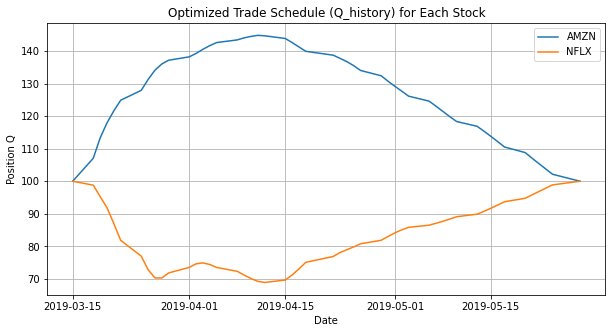

In [169]:
# Plot the final portfolio positions for each stock over time.
plt.figure(figsize=(10, 5))
dates = df_window_opt1["date"].to_numpy()
Q_history1 = np.asarray(Q_history1, dtype=float)
for j in range(m):
    plt.plot(dates, Q_history1[:, j], label=f"{tickers_used[j]}")
plt.xlabel("Date")
plt.ylabel("Position Q")
plt.title("Optimized Trade Schedule (Q_history) for Each Stock")
plt.legend()
plt.grid(True)
plt.show()

## NFLX and JNJ

In [170]:
df_big = pd.read_csv("crsp_data_2.csv")
df_big = clean_data(df_big)
df_big = df_big.sort_values("date").reset_index(drop=True)

nflx_jnj = df_big[(df_big["TICKER"] == "NFLX") | (df_big["TICKER"] == "JNJ")]

nflx_jnj

,PERMNO,date,TICKER,PRC,VOL,RET,SHROUT,NUMTRD
0,22111,2019-01-02,JNJ,127.75000,7631672,-0.010074,2681978,NaN
3,89393,2019-01-02,NFLX,267.66000,11679228,0.000000,436599,128527.0
6,89393,2019-01-03,NFLX,271.20001,14969547,0.013226,436599,142265.0
8,22111,2019-01-03,JNJ,125.72000,8654685,-0.015890,2681978,NaN
10,89393,2019-01-04,NFLX,297.57001,19329677,0.097234,436599,197495.0
...,...,...,...,...,...,...,...,...
7538,22111,2024-12-27,JNJ,145.05000,5588306,-0.003641,2407623,NaN
7541,89393,2024-12-30,NFLX,900.42999,2184055,-0.007845,427458,84238.0
7544,22111,2024-12-30,JNJ,143.34000,6268692,-0.011789,2407623,NaN
7545,89393,2024-12-31,NFLX,891.32001,1859050,-0.010117,427458,63241.0


In [171]:
lookback_days = 50        
window_length = 50          
forecast_horizon = 5        
smoothing_window = 5  
alpha_scale = 0.5         
beta = 0.1                   
w = 1                      
penalty = 0.01            

start_index = 50

opt_start_date = nflx_jnj["date"].iloc[start_index]

In [172]:
# Compute historical covariance using returns
cov_matrix, corr_matrix, tickers_used = compute_historical_covariance(nflx_jnj, opt_start_date, lookback_days)
print("Tickers used for calibration:", tickers_used)

Tickers used for calibration: ['JNJ', 'NFLX']


In [173]:
cov_matrix

array([[1.17480114e-04, 8.14428015e-05],
       [8.14428015e-05, 1.01801888e-03]])

In [174]:
corr_matrix

array([[1.        , 0.23550092],
       [0.23550092, 1.        ]])

In [175]:
# Calibrate stock‑specific parameters τ and γ for each ticker
tau_vec, gamma0_vec, gammaT_vec = calibrate_parameters(nflx_jnj, tickers_used, opt_start_date, lookback_days, c_tau=10, gamma0_default=0.0, c_gamma=0.1)
print("Calibrated τ:", tau_vec)
print("Calibrated γ0:", gamma0_vec)
print("Calibrated γT:", gammaT_vec)

Calibrated τ: [3.29883756 0.31974844]
Calibrated γ0: [0. 0.]
Calibrated γT: [0.00108388 0.00319064]


In [176]:
# Create the optimization dataframe using index slicing.
df_opt = create_optimization_dataframe_from_index(nflx_jnj, tickers_used, start_index, window_length)

In [177]:
# Set initial conditions and target positions.
m = len(tickers_used)
Q_target = np.full(m, 100.0) 
Q0 = np.zeros(m)
J0 = np.zeros(m)

# Run the multi-stock optimization.
df_window_opt2, J_opt2, Q_history2, alpha, gamma, lam = multi_stock_opt_custom(
    df_opt, start_index=0, 
    window_length=window_length,
    forecast_horizon=forecast_horizon,
    smoothing_window=smoothing_window,
    alpha_scale=alpha_scale,
    beta=beta,
    tau_vec=[1, 1],
    w=1,
    penalty=0.1,
    Q_target=Q_target,
    Q0=[100, 100],
    J0=J0,
    gamma0_vec=gamma0_vec,
    gammaT_vec=gammaT_vec,
    cov_matrix=cov_matrix
)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Apr 03 06:50:04 PM: Your problem has 102 variables, 1 constraints, and 0 parameters.
(CVXPY) Apr 03 06:50:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 03 06:50:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 03 06:50:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 03 06:50:04 PM: Compiling problem (target solver=SCS).
(CVXPY) Apr 03 06:50:04 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Cone

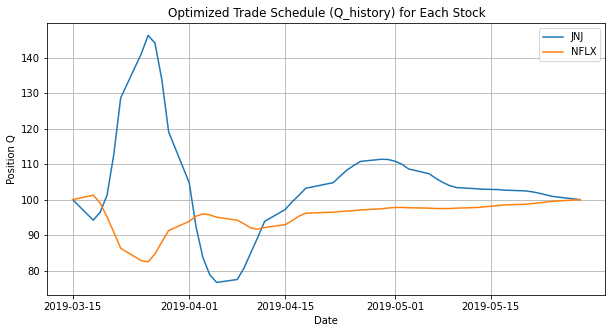

In [178]:
# Plot the final portfolio positions for each stock over time.
plt.figure(figsize=(10, 5))
dates = df_window_opt2["date"].to_numpy()
Q_history2 = np.asarray(Q_history2, dtype=float)
for j in range(m):
    plt.plot(dates, Q_history2[:, j], label=f"{tickers_used[j]}")
plt.xlabel("Date")
plt.ylabel("Position Q")
plt.title("Optimized Trade Schedule (Q_history) for Each Stock")
plt.legend()
plt.grid(True)
plt.show()

## NFLX Trajectories Overlaid

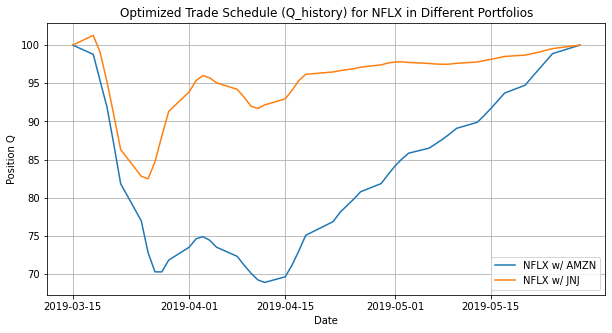

In [179]:
plt.figure(figsize=(10, 5))
plt.plot(dates, Q_history1[:, 1], label="NFLX w/ AMZN")
plt.plot(dates, Q_history2[:, 1], label="NFLX w/ JNJ")
plt.xlabel("Date")
plt.ylabel("Position Q")
plt.title("Optimized Trade Schedule (Q_history) for NFLX in Different Portfolios")
plt.legend()
plt.grid(True)
plt.show()

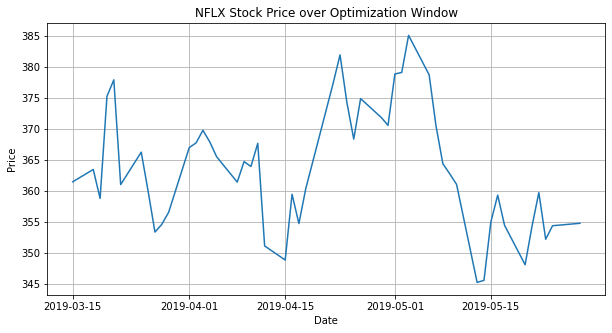

In [180]:
plt.figure(figsize=(10, 5))
plt.plot(dates, np.array(df_window_opt2.loc[:, "PRC_NFLX"]))
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("NFLX Stock Price over Optimization Window")
plt.grid(True)
plt.show()